# Implementing K-Means Clustering

Peter Bull  
2023-06-09

This is my simple implementation of a *K-Means Clustering* algorithm,
foregoing *Within Cluster Sum of Squares* and the *Elbow Rule*

*K-Means* is a clustering algorithm that groups data as specified by the
user (number of clusters, k). It assigns data points to the closest
cluster based on the calculated distances.

Here are the general steps: - Generate random centroids - Calculate the
distance of each datapoint to each centroid - Assign each datapoint to
the centroid it’s closest to - Recalculate the centroids as the mean of
all datapoints assigned to a cluster - Repeat the cluster assignment and
update until the algorithm converges

In [1]:
from fastkaggle import get_dataset
from pathlib import Path
from fastai.tabular.all import *

## Dataset

My first attempt at a clustering algorithm was a botched attempt at a
DBSCAN from scratch. I wanted to use a dataset that was clearly
segmented visually for ease of tracking what was happening. I haven’t
quite worked out the kinks in the DBSCAN notebook yet, but I don’t see
any harm in using it for k-means as well.

The data we’re going to target is the *spending score* as it relates to
*annual income*

In [2]:
path = Path('data/dbscan')
dataset = 'vjchoudhary7/customer-segmentation-tutorial-in-python'
if not path.exists():
    data = get_dataset(path, dataset, unzip=True)
df = pd.read_csv(path/'Mall_Customers.csv', low_memory=False)

In [3]:
df.head()

## Plotting the Target Datapoints

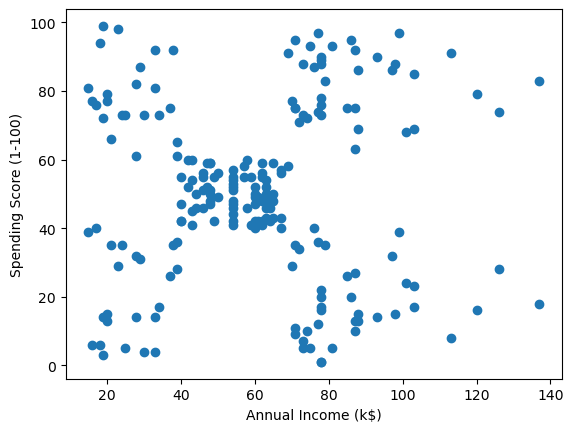

In [4]:
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
plt.scatter(x,y)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

Convert the pandas dataframe to a pytorch tensor to utilize the GPU

In [5]:
x_y_tens = torch.from_numpy(df.to_numpy()[:,3:].astype(float)).to("cuda")

## Picking *k* Centroids

First, a random set of centroids is generated. This is the starting
point for our clustering process. The centroids are the central points
of our clusters. In this implementation, the number of centroids is
chosen by a pretty clear visual grouping pattern in the data

In [6]:
k = 5

Next, we randomly pick those *k* random points as the initial cluster
centroids

In [7]:
sample_idxs = torch.randperm(x_y_tens.shape[0])[:5]
centroids = x_y_tens[sample_idxs]
centroids

tensor([[60., 50.],
        [63., 48.],
        [38., 92.],
        [73., 73.],
        [88., 15.]], device='cuda:0', dtype=torch.float64)

Here I’m just cloning the original centroids to use in a later animation

In [8]:
og_centroids = centroids.clone()

Detaching the tensors to numpy to plot gets pretty tedious, so here I’m
creating a function to lighten the load just a bit.

In [9]:
def np_detach(tens):
    return tens.detach().cpu().numpy()

Plotting the initial data with centroids marked

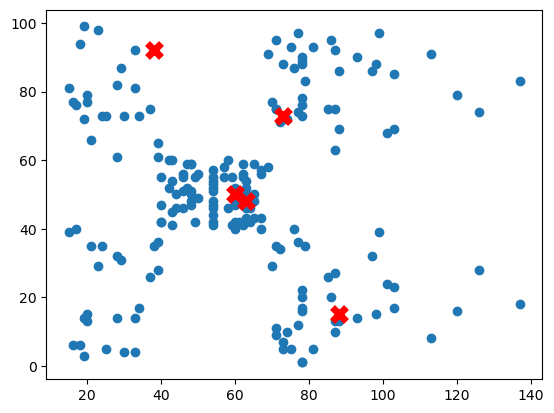

In [10]:
x = np_detach(x_y_tens)[:,0]
y = np_detach(x_y_tens)[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)
for cen in centroids:
    ax.plot(np_detach(cen)[0], np_detach(cen)[1], markersize=10, marker="x", color='r', mew=5)
    

## Calculating the Distance with Frobenius Norm

$$| A |{F} = \sqrt{\sum{i=1}^{m} \sum_{j=1}^{n} |a_{ij}|^2} $$

The *Frobenius Norm* is essentially the square root of the sum of the
absolute squares of its elements. It’s essentially a way to “flatten”
the matrix into a long vector, and then compute the Euclidean length of
that vector.

This will allow us to calculate our distances by way of two tensors,
rather than elementwise operation

In [11]:
def euclidean_dist(a, b):
    return torch.norm(a-b, dim=-1)

## Calculate distance to centroids and assign

Now we calculate the distance of each data point to each centroid

In [12]:
distances = euclidean_dist(x_y_tens.unsqueeze(1), centroids.unsqueeze(0))

Then, assign each point to its nearest cluster

In [13]:
cluster_assignments = torch.argmin(distances, dim=1)

Here I’m just making another copy for later use in an animation

In [14]:
og_cluster_assignments = cluster_assignments.clone()

Plotting our initial cluster assignments:

In [15]:
def plot_clusters(data, centroids, assignments):
    plt.clf()
    data, centroids, assignments = np_detach(data), np_detach(centroids), np_detach(assignments)
    plt.scatter(data[:,0], data[:,1], c=assignments, s=30)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='red', s=60)

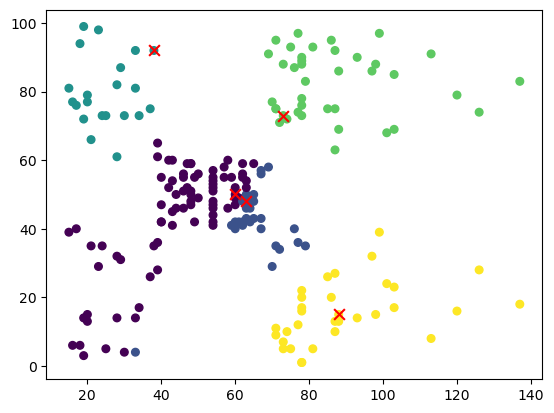

In [16]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

We’ll need to iterate several times over these steps, so we’ll start
aggregating them into functions

In [17]:
def assign_to_nearest_centroid(data, centroids):
    distances = euclidean_dist(data.unsqueeze(1), centroids.unsqueeze(0))
    cluster_assignments = torch.argmin(distances, dim=1)
    return cluster_assignments

Now that we’ve assigned all datapoints to clusters, we have to update
the centroids. This is done by taking the mean of all data points
assigned to a cluster, resulting in a new centroid

In [18]:
def update_centroids(data, cluster_assignments, centroids): 
    new_centroids = torch.zeros_like(centroids)
    for i in range(centroids.shape[0]):
        assigned_points = data[cluster_assignments == i]
        if len(assigned_points) > 0:
            new_centroids[i] = torch.mean(assigned_points, dim=0)
    return new_centroids

In [19]:
new_centroids = update_centroids(x_y_tens, cluster_assignments, centroids)

Plotting our centroid update:

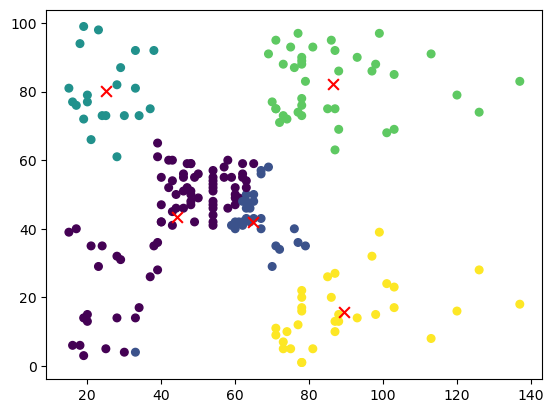

In [20]:
plot_clusters(x_y_tens, new_centroids, cluster_assignments)

## Repeat

Now we’ll run through the assignment/update loop several times and
hopefully converge in the process

In [21]:
def k_means(data, centroids, iterations=10):
    for i in range(iterations):
        cluster_assignments = assign_to_nearest_centroid(data, centroids)
        new_centroids = update_centroids(data, cluster_assignments, centroids)
    cluster_assignments = assign_to_nearest_centroid(data, centroids)
    return cluster_assignments, new_centroids

In [22]:
cluster_assignments, centroids = k_means(x_y_tens, centroids)

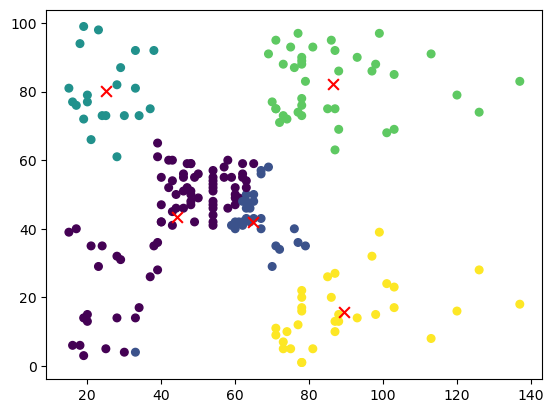

In [23]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

## Animation

Finally, we’ll use our original centroids and cluster assignments to see
it in action

In [24]:
centroids = og_centroids
cluster_assignments = og_cluster_assignments

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

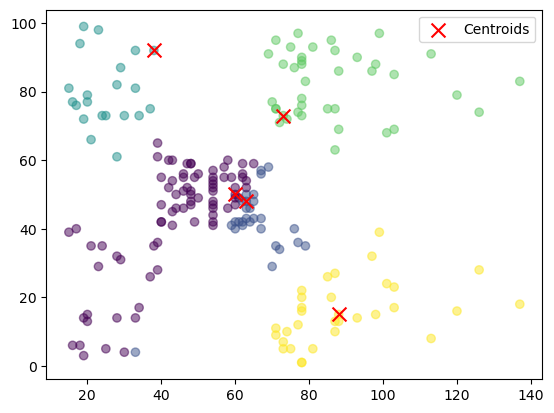

In [26]:
fig, ax = plt.subplots()

# Set up the initial plot
scatter = ax.scatter(np_detach(x_y_tens[:, 0]), np_detach(x_y_tens[:, 1]), c=np_detach(cluster_assignments), cmap='viridis', alpha=0.5)
centroid_plot = ax.scatter(np_detach(centroids[:, 0]), np_detach(centroids[:, 1]), c='red', marker='x', s=100, label='Centroids')
ax.legend()

In [27]:
def init():
    return scatter, centroid_plot

In [28]:
def update(frame):
    global x_y_tens, centroids, cluster_assignments
    
    # Step 1: Assign x_y_tens points to the nearest centroid
    cluster_assignments = assign_to_nearest_centroid(x_y_tens, centroids)

    # Step 2: Update centroids
    updated_centroids = update_centroids(x_y_tens, cluster_assignments, centroids)

    # Update plot
    scatter.set_array(np_detach(cluster_assignments))
    centroid_plot.set_offsets(np_detach(updated_centroids))
    centroids = updated_centroids
    
    return scatter, centroid_plot

In [29]:
ani = FuncAnimation(fig, update, frames=10, init_func=init, blit=True, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

Once 
 
 Loop 
 
 Reflect